In [50]:
import os
import sys
# Make sure all code is in the PATH.
sys.path.append("../src/")

In [51]:
import functools
import lzma
import re

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numba as nb
import numpy as np
import pandas as pd
import pyteomics.mgf
import seaborn as sns
import tqdm.notebook as tqdm
from matplotlib.colors import LogNorm


In [52]:
# Plot styling.
plt.style.use(["seaborn-white", "seaborn-paper"])
plt.rc("font", family="sans-serif")
sns.set_palette(["#9e0059", "#6da7de", "#ee266d", "#dee000", "#eb861e"])
sns.set_context("paper")

## Finished setup, start plotting

In [53]:
analysis_id = "bile_bib"

# similarities = pd.read_parquet("bile_bib_sqrt_True_100000pairs_6min_signals_15i9949specific_delta.parquet")
similarities = pd.read_parquet("bile_bib_sqrt_False_100000pairs_6min_signals_15i9949specific_delta.parquet")
# similarities = pd.read_parquet("gnps_lib_sqrt_False_500000pairs_6min_signals_200maxdelta.parquet")
# similarities = pd.read_parquet("gnps_lib_results_100k.parquet")
similarities.head(5)

,id1,id2,delta_mz,cos_score,cos_matched_intensity,cos_max_contribution,cos_n_greq_2p,mod_score,mod_matched_intensity,mod_max_contribution,mod_n_greq_2p,nl_score,nl_matched_intensity,nl_max_contribution,nl_n_greq_2p
0,CCMSLIB00006584734,CCMSLIB00006584060,16.013,0.381859,0.920830,0.154692,2,0.898646,0.974513,0.417347,4,0.613718,0.875202,0.417347,2
1,CCMSLIB00006584460,CCMSLIB00006582272,16.013,0.246117,0.753341,0.147478,2,0.764078,0.977748,0.411553,5,0.546835,0.899408,0.411553,3
2,CCMSLIB00006583913,CCMSLIB00006583600,16.013,0.354827,0.847325,0.199827,2,0.731148,0.944247,0.309204,4,0.444694,0.860202,0.309204,2
3,CCMSLIB00006583613,CCMSLIB00006584367,15.995,0.040960,0.689988,0.003521,0,0.180091,0.843621,0.119297,1,0.153326,0.627583,0.119297,1
4,CCMSLIB00006582721,CCMSLIB00006583513,15.995,0.087389,0.826667,0.052705,1,0.969469,0.995047,0.596801,5,0.891447,0.970764,0.596801,4


In [54]:
similarities = similarities[(similarities["cos_score"]>0) & (similarities["mod_score"]>0) & (similarities["nl_score"]>0)]
len(similarities)

9513

In [55]:
total = len(similarities)
stats = {
    'total': total,
    'cos higher': len(similarities[similarities["cos_score"]>similarities["nl_score"]])/ total,
    'nl higher': len(similarities[similarities["cos_score"]<similarities["nl_score"]])/ total
}
print(stats)

{'total': 9513, 'cos higher': 0.5594449700409966, 'nl higher': 0.4405550299590035}


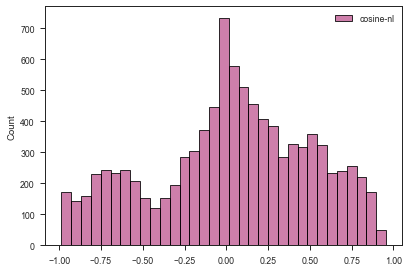

In [56]:
df = pd.DataFrame()
# df['cosine'] = similarities['cosine']
# df['neutral_loss'] = similarities['neutral_loss']
df['cosine-nl'] = similarities['cos_score'] - similarities['nl_score']
ax = sns.histplot(data=df)


plt.savefig("{}_diff.png".format(analysis_id), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

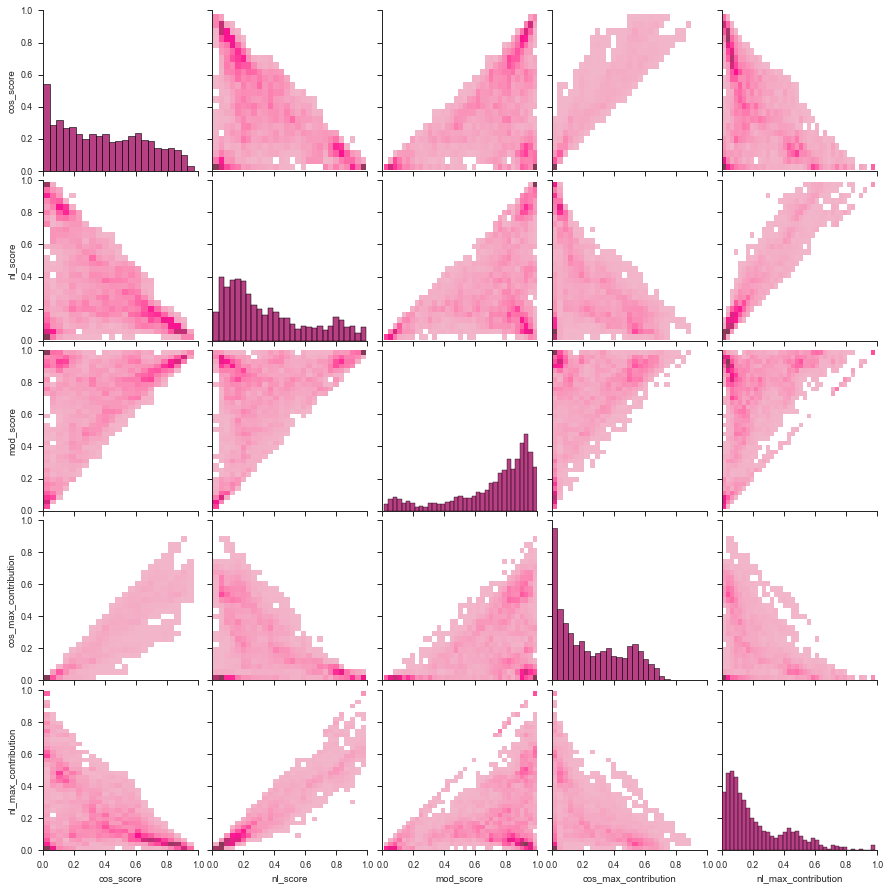

In [57]:
g = sns.pairplot(similarities, kind="hist",
             vars=["cos_score", "nl_score", "mod_score", "cos_max_contribution", "nl_max_contribution"])
for axes in g.axes:
    for a in axes:
        a.set_xlim((0,1))
        a.set_ylim((0,1))

plt.savefig("{}_pair.png".format(analysis_id), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

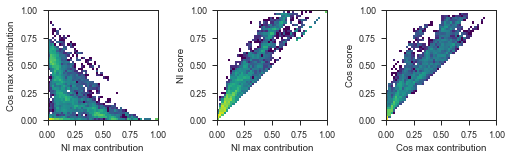

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(7.2, 7.2 / 1.618))

bins = 50
tick_locators = mticker.FixedLocator(np.arange(0, bins + 1, bins / 4))
tick_labels = np.asarray([f"{a:.2f}" for a in np.arange(0, 1.01, 0.25)])
for i, (xlabel, ylabel) in enumerate(
        [
            ["nl_max_contribution", "cos_max_contribution"],
            ["nl_max_contribution", "nl_score"],
            ["cos_max_contribution", "cos_score"]
        ]
    ):
    hist, _, _ = np.histogram2d(
        similarities[xlabel],
        similarities[ylabel],
        bins=bins,
        range=[[0, 1], [0, 1]],
    )
    heatmap = sns.heatmap(
        np.rot90(hist),
        cmap="viridis",
        cbar=False,
        square=True,
        xticklabels=False,
        yticklabels=False,
        ax=axes[i],
        norm=LogNorm(),
    )
    axes[i].yaxis.set_major_locator(tick_locators)
    axes[i].set_yticklabels(tick_labels[::-1])
    axes[i].xaxis.set_major_locator(tick_locators)
    axes[i].set_xticklabels(tick_labels)
    for _, spine in heatmap.spines.items():
        spine.set_visible(True)
    axes[i].set_xlabel(xlabel.replace("_", " ").capitalize())
    axes[i].set_ylabel(ylabel.replace("_", " ").capitalize())

plt.tight_layout()

plt.savefig("{}_contributions.png".format(analysis_id), dpi=300, bbox_inches="tight")
plt.show()
plt.close()